In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import colors
import os
from collections import Counter
import networkx as nx
from griottes import get_cell_properties, generate_delaunay_graph, generate_geometric_graph, plot_2D


# I. Description

This notebook enables the user to reproduce the panels from figure 4 of ["Griottes: a generalist tool for network generation from segmented tissue images"](https://www.biorxiv.org/content/10.1101/2022.01.14.476345v1). The first part of the document shows how to generate a graph object from a CSV. The second part of the notebook contains the code corresponding to the more advanced analysis shown in the paper to demonstrate the power of network-based analysis methods. The data are available on the github release and will be directly downloaded to the local repository.

## 1. Load image and mask of nuclei

First download the image from the latest release of `Griottes` from the GitHub release and load the image to the notebook. The data here is graciously provided by Nicolas Dray and the data has been privously published in "Dynamic spatiotemporal coordination of neural stem cell fate decisions occurs through local feedback in the adult vertebrate brain., *Cell Stem Cell*, Dray et al. (2021)".

In [2]:
import urllib3
import shutil

url = 'https://github.com/BaroudLab/Griottes/releases/download/v1.0-alpha/zebrafish_cell_properties.csv'
filename = 'zebrafish_cell_properties.csv'

if not os.path.exists(filename):
    c = urllib3.PoolManager()

    with c.request('GET',url, preload_content=False) as resp, open(filename, 'wb') as out_file:
        shutil.copyfileobj(resp, out_file)

    resp.release_conn()
else:
    print('dataset already exists')

dataset already exists


In [3]:
zebrafish_cell_properties = pandas.read_csv('zebrafish_cell_properties.csv')

For illustration purposes, we assign different colors to the different cell types:

In [4]:
n_colors = len(zebrafish_cell_properties.cell_type.unique())
color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[zebrafish_cell_properties.loc[i, 'cell_type']] for i in range(len(zebrafish_cell_properties))]

zebrafish_cell_properties['color'] = colors
zebrafish_cell_properties['legend'] = zebrafish_cell_properties['cell_properties']

## 2. Create Delaunay network

We have prepared `zebrafish_cell_properties`, the dataframe containing the relevant single-cell data information. It is provided as an input to `griottes` which then generates a Delaunay network.

In [5]:
descriptors = ['label', 'color', 'legend', 'x', 'y','cell_properties']

In [6]:
G_delaunay = generate_delaunay_graph(zebrafish_cell_properties[descriptors], 
                            descriptors = descriptors, 
                            distance=17,
                            image_is_2D = True)

The generated network can be visualised using specific network visualisation tools:

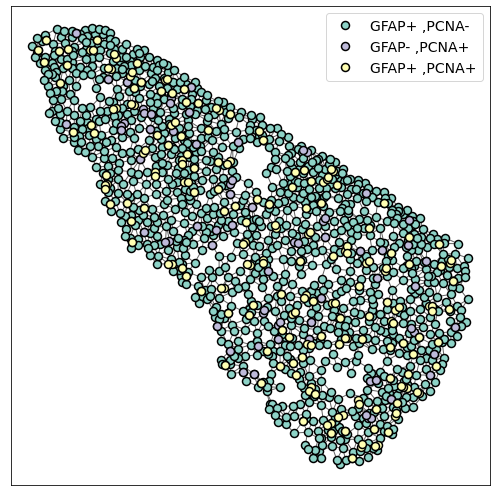

In [7]:
plot_2D(G_delaunay,
        alpha_line = 0.6,
        scatterpoint_size = 8,
        legend = True,
        legend_fontsize = 14,
        figsize = (7,7))

plt.tight_layout()

# II. Analyzing the network properties

As in the previous examples, the following code is used to showcase examples that are included in the publication.

## 1. Tissue composition

We first begin by studying the distribution of cell types within the tissue. This sheds light on the tissue properties.

In [8]:
cell_counts = dict(Counter(zebrafish_cell_properties[descriptors]['cell_properties']))

cell_count_frame = pandas.DataFrame()
for cell_type in cell_counts.keys():
    cell_count_frame.loc[cell_type, 'cell_count'] = cell_counts[cell_type]
    
cell_count_frame['frequency'] = 100*cell_count_frame['cell_count']/cell_count_frame['cell_count'].sum()
cell_count_frame['cell_properties'] = cell_count_frame.index


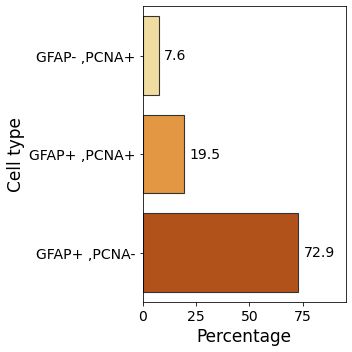

In [9]:
fig, ax = plt.subplots(figsize = (5,5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax = sns.barplot(data = cell_count_frame, 
                 y = 'cell_properties', 
                 x = 'frequency', 
                 palette = 'YlOrBr', 
                 edgecolor=".2", linewidth=1.1)

ax.set_xlabel('Percentage', fontsize=17)
ax.set_ylabel('Cell type', fontsize=17)

ax.bar_label(ax.containers[0], fmt='%.1f', fontsize = 14, padding = 5)
ax.set_xlim(right=95)

plt.tight_layout()

## 2. Degree distribution within the tissue

Then we look at the degree distribution within the sample. The tissue is a 2D sample and so we expect the degrees of individual cells to be slightly lower than in 3D. 

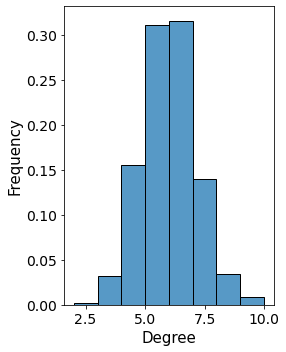

In [10]:
degree_frame = pandas.DataFrame()
i = 0

for a, d in G_delaunay.nodes(data=True):
    
    degree_frame.loc[i, 'degree'] = G_delaunay.degree[a]
    degree_frame.loc[i, 'cell_properties'] = d['cell_properties']
    i += 1
    
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize = (4,5), sharex = True, sharey = True)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

ax = sns.histplot(data = degree_frame[degree_frame.degree > 0],
             x = 'degree',
             binwidth = 1,
             ax = ax, 
             kde=False, 
             stat = 'density')

ax.set_ylabel('Frequency', fontsize = 15)
ax.set_xlabel('Degree', fontsize = 15)

plt.tight_layout()


## 3. Subgraph clusters

Another interesting property is to focus on groups of cells of similar type within the tissue. Using the network approach allows the user to easily analyse the tissue at the single-cell level and look at the distribution of "clusters".

Then, it is possible to focus on the properties of these individual clusters, for example by studying their size as a function of their type.

In [11]:
Connec_Sub = np.zeros(len(G_delaunay)).astype(int)

list_connected_sub = []

cell_properties_dict = nx.get_node_attributes(G_delaunay, 'cell_properties')
cell_types_in_graph = np.unique([cell_properties_dict[node] for node in cell_properties_dict.keys()])
total_size_clusters = pandas.DataFrame(columns = ['cluster_size', 'cell_properties'])

for cell_type in cell_types_in_graph:
    
    local_size_clusters = pandas.DataFrame(columns = ['cluster_size', 'cell_properties'])

    node_list = []
    for x, y in G_delaunay.nodes(data = True):
        if (y['cell_properties'] == cell_type):
            node_list.append(x)
            
    single_cell_type_subgraph = G_delaunay.subgraph(node_list)
    
    connected_subgraphs_size = [len(c) for c in sorted(nx.connected_components(single_cell_type_subgraph), key=len, reverse=True)]
    
    local_size_clusters['cluster_size'] = connected_subgraphs_size
    local_size_clusters['cell_properties'] = cell_type
    
    total_size_clusters = total_size_clusters.append(local_size_clusters)
    
    

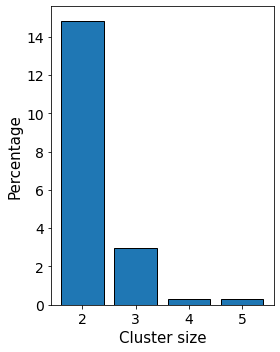

In [12]:
labels, counts = np.unique(total_size_clusters.loc[total_size_clusters.cell_properties != 'GFAP+ ,PCNA-', 'cluster_size'], 
                           return_counts=True)

fig, ax = plt.subplots(1,1,figsize = (4,5), sharex = True, sharey = True)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

plt.bar(labels[1:], 100*counts[1:]/counts.sum(), 
        align='center',
        edgecolor = 'k',
        linewidth = 1)

ax.set_ylabel('Percentage', fontsize = 15)
ax.set_xlabel('Cluster size', fontsize = 15)

plt.tight_layout()